<a href="https://colab.research.google.com/github/nidhimath/moneyReader/blob/master/source/model/BinaryClassification/BinaryClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# baseline model with dropout for the dogs vs cats dataset
import sys
from keras.utils import to_categorical
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

from keras.models import load_model
from PIL import Image
import numpy as np
import sys

import skimage
import scipy
from scipy import signal
from skimage import io
from skimage.filters import gaussian
from skimage.transform import rescale

import time
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.constraints import maxnorm
from keras.utils import np_utils
from keras.datasets import cifar10
import matplotlib.pyplot as plt
import pickle

## Changing the Data

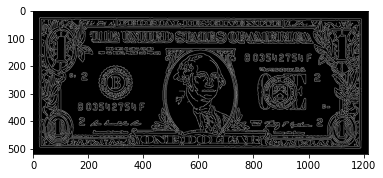

In [ ]:
dollar = io.imread('/Users/Nidhi/Downloads/US_one_dollar_bill,_obverse,_series_2009.jpeg', as_gray=True)

# dollar = rescale(dollar, 0.1, anti_aliasing=True)
dollar = skimage.img_as_float32(dollar)

filt8 = skimage.feature.canny(dollar, sigma=2)
plt.imshow(filt8, cmap="gray")

In [ ]:
dollar = io.imread('/Users/Nidhi/Downloads/US_one_dollar_bill,_obverse,_series_2009.jpg', as_gray=True)

plt.imshow(dollar, cmap="gray")

## Creating and Testing the model

In [ ]:
image_size = 64

In [ ]:
# Loading all of the images into CIFAR-10 format
def load_cfar10_batch(fileName):
    with open(fileName, mode='rb') as file:
        # note the encoding type is 'latin1'
        batch = pickle.load(file, encoding='latin1')

    input_features = batch['data']
    print(input_features)

    numImages = (int(len(input_features)/(3*image_size*image_size)))
    print(numImages)

    features = input_features.reshape(numImages, 3, image_size, image_size).transpose(0, 2, 3, 1)

    labels = batch['labels']
    return features, labels

In [ ]:
# Loading in the data
(X_train, y_train) = load_cfar10_batch('/Users/Nidhi/PycharmProjects/PracticeAI/cifar10-converter/cifar10-ready.bin')

# Need to give test data as well
(X_test, y_test) = load_cfar10_batch('/Users/Nidhi/PycharmProjects/PracticeAI/cifar10-converter/cifar10-ready-testData.bin')


plt.imshow(X_train[1])
print("Class : ",y_train[1])

In [ ]:
# Normalizing the inputs from 0-255 to between 0 and 1 by dividing by 255
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train / 255.0
X_test = X_test / 255.0


# Designing the model
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
class_num = y_test.shape[1]

In [ ]:
# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dropout(0.5))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

In [ ]:
def define_model_binary():
  
  # Creating the Model
  model = Sequential()


  # Adding the first layer
  model.add(Conv2D(32, (3, 3), input_shape=X_train.shape[1:], padding='same'))
  model.add(Activation('relu'))
  model.add(Dropout(0.25))
  model.add(BatchNormalization())


  # Second layer
  model.add(Conv2D(64, (3, 3), padding='same'))
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(BatchNormalization())


  # 3rd layer
  model.add(Conv2D(128, (3, 3), padding='same'))
  model.add(Activation('relu'))
  model.add(Dropout(0.25))
  model.add(BatchNormalization())

  # Flattening the data
  model.add(Flatten())

  model.add(Dense(256, kernel_constraint=maxnorm(3)))
  model.add(Activation('relu'))
  model.add(Dropout(0.25))
  model.add(BatchNormalization())


  model.add(Dense(128, kernel_constraint=maxnorm(3)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  model.add(Dense(class_num))
  model.add(Activation('softmax'))

  return model

In [ ]:
def compile_model_binary(model):
  optimizer = 'adam'
  model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
  print(model.summary())

In [ ]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Classification Accuracy')
	pyplot.plot(history.history['accuracy'], color='blue', label='train')
	pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
	# save plot to file
	filename = sys.argv[0].split('/')[-1]
	pyplot.savefig(filename + '_plot.png')
	pyplot.close()

In [ ]:
# run the test harness for evaluating a model
def run_test_harness():
	# define model
	model = define_model()
	# create data generator
	datagen = ImageDataGenerator(rescale=1.0/255.0)
	# prepare iterator
	train_it = datagen.flow_from_directory('dataset_dogs_vs_cats/train/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	test_it = datagen.flow_from_directory('dataset_dogs_vs_cats/test/',
		class_mode='binary', batch_size=64, target_size=(200, 200))
	# fit model
	history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
		validation_data=test_it, validation_steps=len(test_it), epochs=50, verbose=0)
	# evaluate model
	_, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)


In [ ]:
def run_test_binary():
  model = define_model_binary()
  compile_model_binary(model)

  epochs = 30
  seed = 21
  numpy.random.seed(seed)
  model.fit(X_train, y_train,
            validation_data=(X_test, y_test),
            epochs=epochs,
            batch_size=image_size)

  scores = model.evaluate(X_test, y_test, verbose=0)
  print("Accuracy: %.2f%%" % (scores[1]*100))
  model.save('blind.h5')

In [ ]:
 # entry point, run the test harness
run_test_binary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_43 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
activation_85 (Activation)   (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_43 (Dropout)         (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization_71 (Batc (None, 64, 64, 32)        128       
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
activation_86 (Activation)   (None, 64, 64, 64)        0         
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 32, 32, 64)      

In [ ]:
batch_size = 64

model = load_model('blind.h5')

data = []

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

im = Image.open("/Users/Nidhi/Downloads/Blind Project/Binary/data/train/0/usa_1_c 1969_f_orig_reg_id11762-1024xauto.png")
img = im.load()

for color in range(0, 3):
    for x in range(0, batch_size):
        for y in range(0, batch_size):
            data.append(img[x, y][color])

img = np.reshape(data,[1, 3, batch_size,
                 batch_size]).transpose(0, 2, 3, 1)

classes = model.predict_classes(img)

print(classes)


[1]
